# Plot seasonal cycle of CO$_2$ and O$_2$ fluxes and their drivers

In [270]:
%matplotlib inline
from config_calc import *

import os
import sys
import socket
import numpy as np
import xarray as xr

from datetime import datetime
import grid_tools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

import xcalendar as xcal
import flux_products

<xarray.Dataset>
Dimensions:          (nv: 4, time: 24)
Coordinates:
  * time             (time) float64 16.0 26.0 45.5 55.5 ... 329.5 350.0 360.0
Dimensions without coordinates: nv
Data variables:
    xc               (time) float64 nan -4.5 nan -4.5 nan ... nan -4.5 nan -4.5
    yc               (time) float64 nan -54.52 nan -54.52 ... -54.52 nan -54.52
    xv               (nv, time) float64 nan -5.063 nan ... -5.063 nan -5.063
    yv               (nv, time) float64 nan -55.09 nan ... -53.96 nan -53.96
    area             (time) float64 1.41e+11 9.018e+09 ... 1.41e+11 9.018e+09
    date             (time) float64 2e+07 2e+07 2e+07 ... 2e+07 2e+07 2e+07
    O2_FLUX_BIO_SEA  (time) float64 nan 6.705 nan 4.783 ... nan 5.266 nan 6.827
    O2_FLUX_SEA      (time) float64 nan 13.48 nan 9.103 ... nan 10.12 nan 13.91
    O2_FLUX_THM_SEA  (time) float64 nan 6.775 nan 4.32 ... nan 4.857 nan 7.085
    PCO2_SW          (time) float64 341.3 nan 341.4 nan ... 356.8 nan 348.8 nan
    MOD_SST    

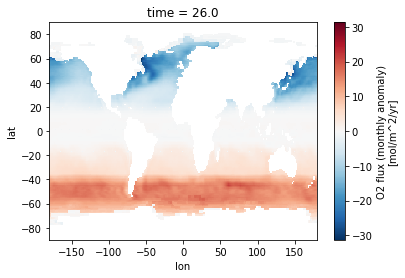

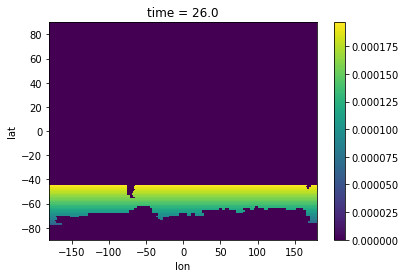

In [271]:
droot = '/glade/work/mclong/garcia-keeling'
files = ['o2flux_biosea_global.adjusted.20171211.nc',
         'o2flux_sea_global.adjusted.20171211.nc',
         'o2thermal_sea_global.adjusted.20171211.nc']

ds = xr.Dataset()
for f in files:
    ds = xr.merge((ds, xr.open_dataset(f'{droot}/{f}')))

plt.figure()
ds.O2_FLUX_SEA.isel(time=0).plot()

rmask = ds.O2_FLUX_SEA.notnull() * ds.area.where((ds.lat<=-44.)).fillna(0.)
wgt = rmask / rmask.sum(dim=['lon','lat'])
ds_o2 = (ds * wgt).sum(dim=['lon','lat'])

plt.figure()
wgt.isel(time=0).plot()
dss

In [272]:
droot = os.path.join(dataroot,'pco2-ldeo')
ds = xr.open_dataset(os.path.join(droot,'ldeo_monthly_clim_v2009_c20150807.nc'))
ds = ds.rename({'FLUXMOLM2Y':'CO2_FLUX'})

ds['area'] = xr.DataArray(np.empty((len(ds.lat),len(ds.lon))),dims=('lat','lon'))
ds.area.attrs['units'] = 'm^2'
ds.area.values = grid_tools.compute_grid_area(ds.lon.values,ds.lat.values)
ds.info()

total area = 5.1009969907076156e+14
check area = 5.1009969907076156e+14
xarray.Dataset {
dimensions:
	lat = 45 ;
	lon = 72 ;
	time = 12 ;

variables:
	float64 lat(lat) ;
	float64 lon(lon) ;
	float64 PCO2_SW(time, lat, lon) ;
		PCO2_SW:units = \\muatm ;
		PCO2_SW:long_name = pCO2_sw ;
	float64 MOD_SST(time, lat, lon) ;
		MOD_SST:units = ^\\circC ;
		MOD_SST:long_name = SST observations ;
	float64 VCO2_AIR(time, lat, lon) ;
		VCO2_AIR:units = ppm ;
		VCO2_AIR:long_name = CO_2 in dry air ;
	float64 PCO2_AIR(time, lat, lon) ;
		PCO2_AIR:units = \\muatm ;
		PCO2_AIR:long_name = pCO_2 Atmosphere ;
	float64 PBARO(time, lat, lon) ;
		PBARO:units = millibars ;
		PBARO:long_name = SLP ;
	float64 SST(time, lat, lon) ;
		SST:units = ^\\circC ;
		SST:long_name = SST Climatology ;
	float64 SAL(time, lat, lon) ;
		SAL:units =   ;
		SAL:long_name = Salinty ;
	float64 DELTA_PCO2(time, lat, lon) ;
		DELTA_PCO2:units = \\muatm ;
		DELTA_PCO2:long_name = \\DeltapCO_2 ;
	float64 WINDSPEED(time, lat, lon) ;

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


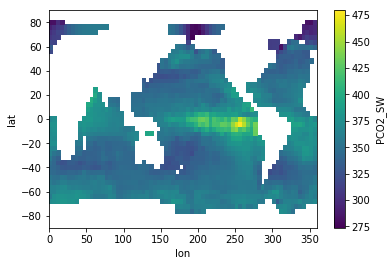

In [273]:
ds.PCO2_SW.mean(dim='time').plot()

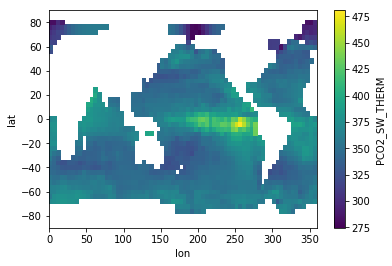

In [274]:
ds['PCO2_SW_THERM'] = ds.PCO2_SW.mean('time') * np.exp(0.0423 * (ds.SST - ds.SST.mean('time')))
ds.PCO2_SW_THERM.mean(dim='time').plot()

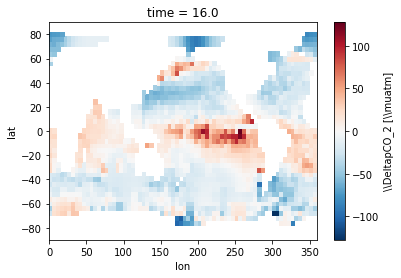

In [275]:
ds.DELTA_PCO2.isel(time=0).plot()

RMS diff: 0.064166


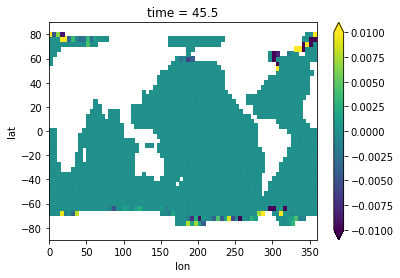

In [276]:
DELTA_PCO2_EST = ds.PCO2_SW - ds.PCO2_AIR
np.testing.assert_allclose(DELTA_PCO2_EST.values, ds.DELTA_PCO2.values)

fice = ds.ICE_PCT / 100.;

ypm = xr.DataArray(xcal.dpm['noleap'] / 365., dims=('time'))

GASCOEFSW_molm2yr_muatm = ds.GASCOEFSW / ypm

CO2_FLUX_EST =  (1. - fice) * GASCOEFSW_molm2yr_muatm * (ds.PCO2_SW - ds.PCO2_AIR)

print(f'RMS diff: {((CO2_FLUX_EST - ds.CO2_FLUX) ** 2).sum().values:0.6f}')

(CO2_FLUX_EST - ds.CO2_FLUX).isel(time=1).plot(vmin=-1e-2, vmax=1e-2)

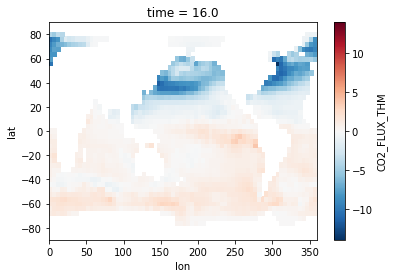

In [277]:
ds['CO2_FLUX_THM'] = (1. - fice) * GASCOEFSW_molm2yr_muatm * (ds.PCO2_SW_THERM - ds.PCO2_AIR)
ds['CO2_FLUX_BIO'] = ds.CO2_FLUX - ds.CO2_FLUX_THM
ds.CO2_FLUX_THM.isel(time=0).plot()

In [278]:
rmask = ds.CO2_FLUX.notnull() * ds.area.where((ds.lat<=-44.)).fillna(0.)
wgt = rmask / rmask.sum(dim=['lon','lat'])
ds_co2 = (ds * wgt).sum(dim=['lon','lat'])
ds_co2

<xarray.Dataset>
Dimensions:        (time: 12)
Coordinates:
  * time           (time) float64 16.0 45.5 75.0 105.5 ... 289.0 319.5 350.0
Data variables:
    PCO2_SW        (time) float64 341.3 341.4 346.5 348.8 ... 362.8 356.8 348.8
    MOD_SST        (time) float64 5.569 6.023 6.068 5.664 ... 3.91 4.262 4.896
    VCO2_AIR       (time) float64 365.9 365.8 365.9 366.0 ... 367.6 367.6 367.4
    PCO2_AIR       (time) float64 357.2 357.2 357.3 357.4 ... 358.7 358.7 358.7
    PBARO          (time) float64 998.5 999.2 999.2 998.6 ... 996.7 997.0 998.1
    SST            (time) float64 5.752 6.15 5.925 5.321 ... 3.443 3.983 4.869
    SAL            (time) float64 34.04 34.01 34.02 34.07 ... 34.16 34.15 34.12
    DELTA_PCO2     (time) float64 -15.91 -15.73 -10.86 ... 4.045 -1.848 -9.896
    WINDSPEED      (time) float64 9.417 9.996 10.6 11.01 ... 10.76 10.05 9.441
    P_VEL_SW06     (time) float64 16.59 18.44 20.32 21.57 ... 19.69 17.64 16.19
    GASCOEFSW      (time) float64 0.006152 0.006858

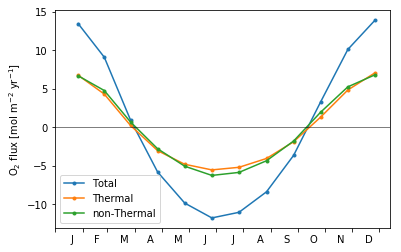

In [279]:
ds_o2.O2_FLUX_SEA.plot(marker='.', label='Total')
ds_o2.O2_FLUX_THM_SEA.plot(marker='.', label='Thermal')
ds_o2.O2_FLUX_BIO_SEA.plot(marker='.', label='non-Thermal')
plt.axhline(0, linewidth=0.5, color='k')

plt.ylabel('O$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')
plt.xlabel('')

plt.xticks(np.concatenate(([0.], np.cumsum(xcal.dpm['noleap']))))
plt.gca().set_xticklabels([f'{m}       ' for  m in ['']+xcal.month_letter])
plt.legend()

plt.savefig(f'{diro["fig"]}/o2-therm-bio-GK01.png', bbox_inches='tight')

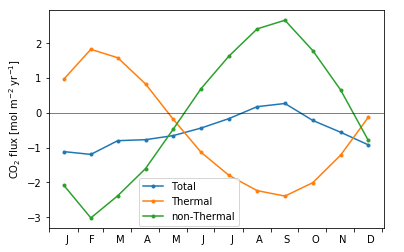

In [280]:
ds_co2.CO2_FLUX.plot(linestyle='-', marker='.', label='Total')
ds_co2.CO2_FLUX_THM.plot(marker='.', label='Thermal')
ds_co2.CO2_FLUX_BIO.plot(marker='.', label='non-Thermal')
plt.axhline(0, linewidth=0.5, color='k')

plt.ylabel('CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')
plt.xlabel('')

plt.xticks(np.concatenate(([0.], np.cumsum(xcal.dpm['noleap']))))
plt.gca().set_xticklabels([f'{m}       ' for  m in ['']+xcal.month_letter])
plt.legend(loc=(0.27, 0.01))

plt.savefig(f'{diro["fig"]}/co2-therm-bio-T09.png', bbox_inches='tight')

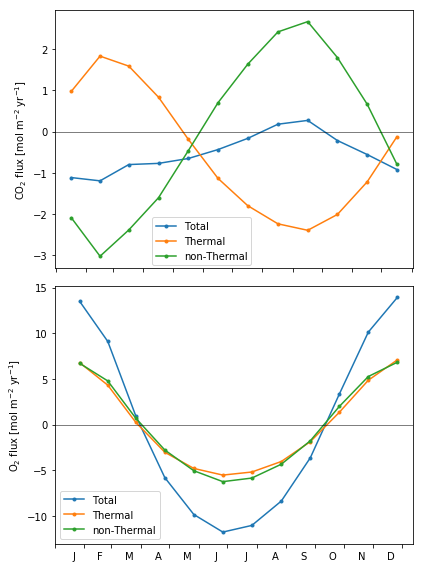

In [289]:
fig = plt.figure(figsize=(6, 8))

ax = fig.add_subplot(2, 1, 1)
ds_co2.CO2_FLUX.plot(linestyle='-', marker='.', label='Total')
ds_co2.CO2_FLUX_THM.plot(marker='.', label='Thermal')
ds_co2.CO2_FLUX_BIO.plot(marker='.', label='non-Thermal')
plt.axhline(0, linewidth=0.5, color='k')

plt.ylabel('CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')
plt.xlabel('')

plt.xticks(np.concatenate(([0.], np.cumsum(xcal.dpm['noleap']))))
plt.gca().set_xticklabels([f'' for  m in ['']+xcal.month_letter])
plt.legend(loc=(0.27, 0.01))

ax = fig.add_subplot(2, 1, 2)
ds_o2.O2_FLUX_SEA.plot(marker='.', label='Total')
ds_o2.O2_FLUX_THM_SEA.plot(marker='.', label='Thermal')
ds_o2.O2_FLUX_BIO_SEA.plot(marker='.', label='non-Thermal')
plt.axhline(0, linewidth=0.5, color='k')

plt.ylabel('O$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')
plt.xlabel('')

plt.xticks(np.concatenate(([0.], np.cumsum(xcal.dpm['noleap']))))
plt.gca().set_xticklabels([f'{m}       ' for  m in ['']+xcal.month_letter])
plt.legend()


plt.tight_layout()

plt.savefig(f'{diro["fig"]}/co2-o2-therm-bio-T09-GK01.png', bbox_inches='tight')